# Physics-Informed Neural Networks (PINNs) in Jax

From this video by 'Machine Learning & Simulation':
 - https://www.youtube.com/watch?v=-dQFrxNuxys

This is the 1D Poisson equation:

$$\frac{\partial^2 u}{\partial x^2} = -f(x), x \in (0,1)$$

Boundary condition:

$$ u(0) = u(1) = 0 $$

My intuitive explanation:

- The rate of change of the slope of u in the x-direction, between 0 and 1, must be equal to the negative of a function, $f(x)$, and $u$ must be zero at $x=0$ and $x=1$.
- The goal is to find a solution $\hat{u}(x)$ that satisfies this PDE, or is close to the true solution, which in this case can be found analytically but in general may be difficult to solve.
- Note that typically PDEs are a function of more than one variable, and not only spacial variables like $x$, but also time, $t$.
- A neural network will be used to model $u$, so the solution will be denoted $\hat{u}(x, \theta)$ where $\theta$ is a vector of parameters of the NN.

Note: this is a 'data-free' problem.  The neural network is only trained on the physics-based exact model.

Loss function:

$$ \mathcal{L}_{\text{PDE}}(\theta) = \frac{1}{2L} \sum_{i=1}^L{ \left( \frac{\partial^2 \hat{u}_\theta}{\partial x^2} \Bigg\rvert_{x=x^{[i]}} + f(x^{[i]})\right ) ^2 } \hspace{1cm} \text{with} \hspace{1cm} x^{[i]}\in\mathcal{U}(0,1) $$

Note that auto-differentiation can be used to compute $\frac{\partial^2 \hat{u}_\theta}{\partial x^2}$ and then the whole loss function is differentiated w.r.t. the parameters for use in gradient descent algorithm.

In addition a loss function is used to ensure convergence to the boundary condition:

$$\mathcal{L}_{\text{BC}}(\theta) = \frac{1}{2} \left( \hat{u}_\theta(0) - 0 \right)^2 + \frac{1}{2} \left( \hat{u}_\theta(1) - 1 \right)^2$$

The combined loss function to be minimized:

$$\mathcal{L}(\theta) = \mathcal{L}_{\text{PDE}}(\theta) + \lambda \mathcal{L}_{\text{BC}}(\theta)$$

where $\lambda$ is a loss weight to magnify the boundary condition loss.

In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import optax
import matplotlib.pyplot as plt
from platform import python_version
python_version()

'3.10.13'

In [2]:
N_DOF_FD = 100
N_COLLOCATION_POINTS = 50
LEARNING_RATE = 1e-3
N_OPTIMIZATION_EPOCHS = 10_000
BC_LOSS_WEIGHT = 400


In [3]:
# For reproducibility
key = jr.PRNGKey(42)

In [4]:
# The PINN is referred to as a 'coordinate network' represented as an MLP
key, init_key = jr.split(key)
pinn = eqx.nn.MLP(
    in_size='scalar',
    out_size='scalar',
    width_size=10,
    depth=4,
    activation=jax.nn.sigmoid,
    key=init_key
)

In [5]:
# Test at an arbitrary point
pinn(0.2)

Array(-0.68502796, dtype=float32)

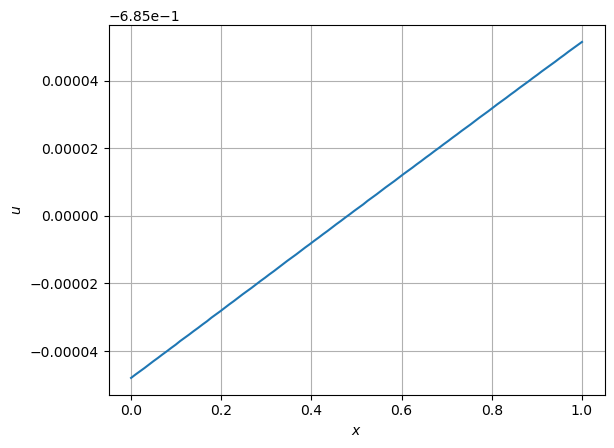

In [6]:
# Establish reference solution
mesh_full = jnp.linspace(0., 1., N_DOF_FD + 2)

# Test PINN again
u_pred = jax.vmap(pinn)(mesh_full)
plt.plot(mesh_full, u_pred)
plt.xlabel('$x$')
plt.ylabel('$u$')
plt.grid()
plt.show()

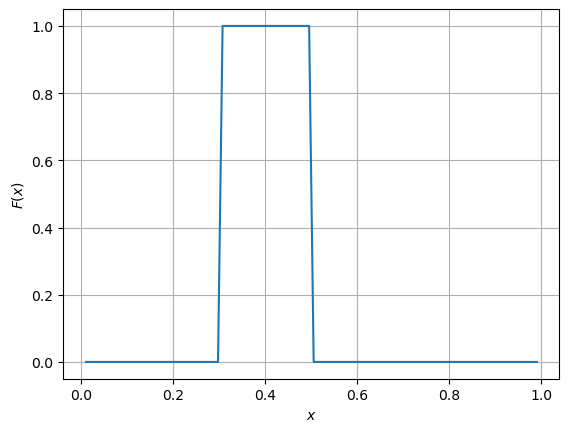

In [7]:
# Define the forcing function
rhs_function = lambda x: jnp.where((x > 0.3) & (x < 0.5), 1., 0.)
mesh_interior = mesh_full[1:-1]
rhs_evaluated = rhs_function(mesh_interior)
plt.plot(mesh_interior, rhs_evaluated)
plt.xlabel('$x$')
plt.ylabel('$F(x)$')
plt.grid()
plt.show()

In [8]:
# Solve using finite-differences
dx = mesh_interior[1] - mesh_interior[0]

# Create the finite-difference system matrix (a tri-diagonal matrix)
A = jnp.diag(jnp.ones(N_DOF_FD - 1), -1) + jnp.diag(jnp.ones(N_DOF_FD - 1), 1) - jnp.diag(2 * jnp.ones(N_DOF_FD))
assert jnp.array_equal(A[:3, :3], jnp.array([
    [ -2.,   1.,   0.],
    [  1.,  -2.,   1.],
    [  0.,   1.,  -2.],
]))
# Scale
A /= dx**2

finite_difference_solution = jnp.linalg.solve(A, -rhs_evaluated)

In [9]:
# Convenience function to pad the solution
wrap_bc = lambda u: jnp.pad(u, (1, 1), mode='constant')

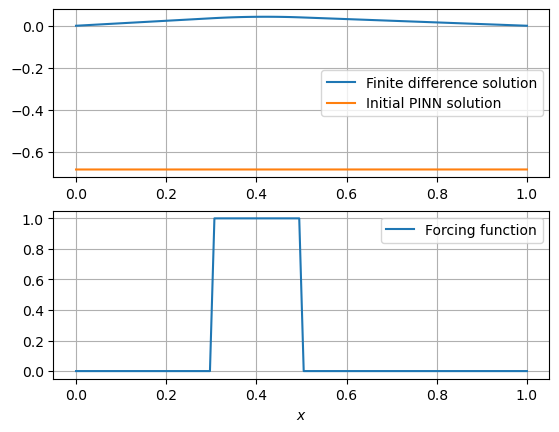

In [10]:
plt.subplot(211)
plt.plot(mesh_full, wrap_bc(finite_difference_solution), label='Finite difference solution')
plt.plot(mesh_full, jax.vmap(pinn)(mesh_full), label='Initial PINN solution')
plt.legend()
plt.grid()

plt.subplot(212)
plt.plot(mesh_full, wrap_bc(rhs_evaluated), label='Forcing function')
plt.xlabel('$x$')
plt.legend()
plt.grid()
plt.show()

Note: he refers to the differences between the model and the forcing function as the 'residuum'

In [11]:
def pde_residuum(network, x):
    # Second derivative:
    return jax.grad(jax.grad(network))(x) + rhs_function(x)

# Test
pde_residuum(pinn, 0.8)

Array(-2.5913748e-06, dtype=float32)

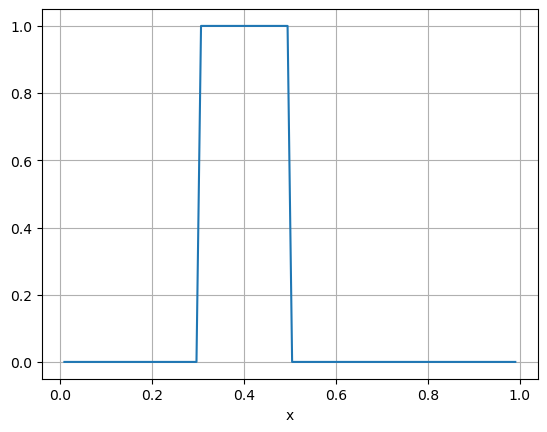

In [12]:
# Test by computing loss on the meshgrid
loss = jax.vmap(pde_residuum, in_axes=(None, 0))(pinn, mesh_interior)
plt.plot(mesh_interior, loss)
plt.xlabel('x')
plt.grid()

In [13]:
# Now generate random collocation points
key, sampling_key = jr.split(key)
collocation_points = jr.uniform(sampling_key, (N_COLLOCATION_POINTS, ), minval=0.001, maxval=0.999)

def loss_fn(network):
    pde_residuum_at_collocation_points = jax.vmap(pde_residuum, in_axes=(None, 0))(network, collocation_points)
    pse_loss_contribution = 0.5 * jnp.mean(jnp.square(pde_residuum_at_collocation_points))
    left_bc_residuum = network(0.0) - 0.0
    right_bc_residuum = network(1.0) - 0.0
    bc_residuum_contribution = 0.5 * (
        jnp.mean(jnp.square(left_bc_residuum))
         + jnp.mean(jnp.square(right_bc_residuum))
    )
    total_loss = pse_loss_contribution + BC_LOSS_WEIGHT * bc_residuum_contribution
    return total_loss

loss_fn(pinn)

Array(187.77904, dtype=float32)

In [14]:
# Training loop
optimizer = optax.adam(LEARNING_RATE)
opt_state = optimizer.init(eqx.filter(pinn, eqx.is_array))

@eqx.filter_jit
def make_step(network, state):
    loss, grad = eqx.filter_value_and_grad(loss_fn)(network)
    updates, new_state = optimizer.update(grad, state, network)
    new_network = eqx.apply_updates(network, updates)
    return new_network, new_state, loss

loss_history = []
for epoch in range(N_OPTIMIZATION_EPOCHS):
    pinn, opt_state, loss = make_step(pinn, opt_state)
    loss_history.append(loss)
    if epoch % 100 == 0:
        print(f"{epoch}, loss: {loss}")
    

0, loss: 187.77903747558594
100, loss: 3.1622414588928223
200, loss: 0.09001067280769348
300, loss: 0.0900062769651413
400, loss: 0.09000619500875473
500, loss: 0.09000609815120697
600, loss: 0.09000597894191742
700, loss: 0.09000585973262787
800, loss: 0.09000572562217712
900, loss: 0.09000557661056519
1000, loss: 0.09000541269779205
1100, loss: 0.09000524133443832
1200, loss: 0.0900050699710846
1300, loss: 0.09000486135482788
1400, loss: 0.09000464528799057
1500, loss: 0.09000442922115326
1600, loss: 0.09000419080257416
1700, loss: 0.09000393748283386
1800, loss: 0.09000366181135178
1900, loss: 0.09000338613986969
2000, loss: 0.09000308811664581
2100, loss: 0.09000277519226074
2200, loss: 0.09000244736671448
2300, loss: 0.09000209718942642
2400, loss: 0.09000174701213837
2500, loss: 0.09000135958194733
2600, loss: 0.0900009498000145
2700, loss: 0.09000053256750107
2800, loss: 0.09000009298324585
2900, loss: 0.08999964594841003
3000, loss: 0.08999915421009064
3100, loss: 0.08999864757

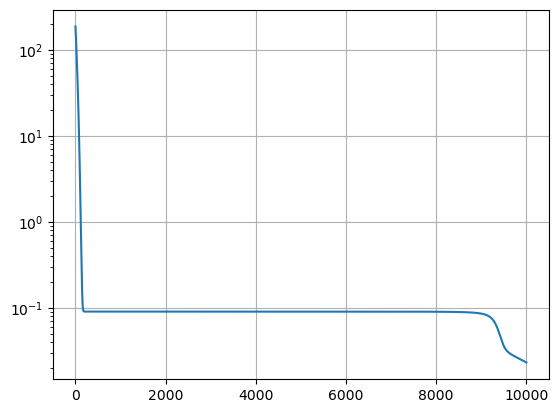

In [15]:
plt.plot(loss_history)
plt.yscale('log')
plt.grid()
plt.show()

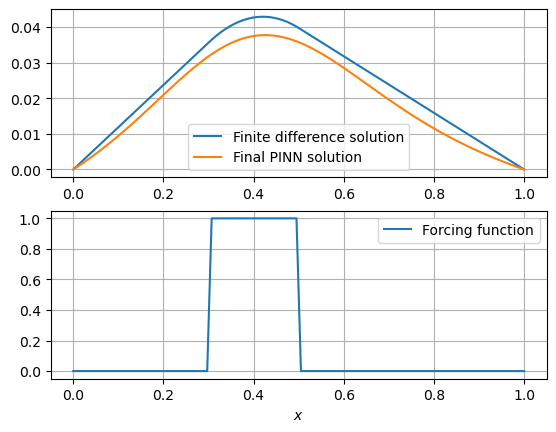

In [16]:
plt.figure()
plt.subplot(211)
plt.plot(mesh_full, wrap_bc(finite_difference_solution), label='Finite difference solution')
plt.plot(mesh_full, jax.vmap(pinn)(mesh_full), label='Final PINN solution')
plt.legend()
plt.grid()

plt.subplot(212)
plt.plot(mesh_full, wrap_bc(rhs_evaluated), label='Forcing function')
plt.xlabel('$x$')
plt.legend()
plt.grid()
plt.show()

In [17]:
# Do some investigation of the solution
pinn(0.33)

Array(0.03417772, dtype=float32)

In [18]:
-jax.grad(jax.grad(pinn))(0.4)

Array(0.78636986, dtype=float32)

In [19]:
rhs_function(0.4)

Array(1., dtype=float32, weak_type=True)